<a href="https://colab.research.google.com/github/DavidScanu/cas-pratique-reconnaissance-iris/blob/main/notebooks/reconnaissance_iris_lr_classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://img.freepik.com/free-photo/magnified-single-yellow-fish-eye-with-abstract-pattern-generated-by-ai_188544-9714.jpg"></img>

# Cas Pratique : Reconnaissance d'iris

**David Scanu** - Normand'IA 2023-2024

---

Vous êtes un développeur IA, votre entreprise vous a confié la mission de **développer une interface de reconnaissance d’oeil pour une entreprise souhaitant authentifier ses 45 employés** à partir d’un scan de leurs yeux.

---

## Partie 1 : Classification oeil gauche ou droit

Développement d'un classificateur qui détecte si l'image est un oeil gauche ou un oeil droit.

---

## Etapes de développement du modèle

- Import des bibliothèques
- Connection à Google Drive
- Importation des images depuis Google Drive
- Variables principales
- Construction du jeu de données
- Split du jeu de données en données d'entraînement et données de test
- Encodage des labels (Label Encoder)
- One-Hot Encoding des labels (to_categorical)
- Augmentation des données (Data Augmentation)
- Prétraitement des images (redimensionnement et mise à l'échelle)
- Fonctions de callbacks pour l'entraînement
- Architecture du modèle
- Entrainement du modèle
- Sauvegarde du modèle
- Sauvegarde du "label encoder"
- Importer le modèle et le "label encoder"
- Prédictions avec les données de test augmentées
- Performances du modèle
- Inférence avec une image
- Montrer les images mal classées

---

## Améliorations possible :

- MLFlow
- Tensorboard

## Import des bibliothèques

In [ ]:
import os
import random
import datetime
import shutil
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import to_categorical

from PIL import Image
import cv2

In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
tf.version.VERSION

'2.14.0'

## Connection à Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importation des images depuis Google Drive

In [ ]:
!unzip -qq "/content/drive/MyDrive/Microsoft IA Simplon ISEN/Passage-titre/Cas pratique 01 (E2) - Reconnaissance iris/consignes/MMU-Iris-Database.zip"

## Variables principales

In [ ]:
# Images are 320px width, 240px height and 3 color layers deep (RVB)
img_width = 320
img_height = 240
img_channels = 3
img_dim = (img_height, img_width, img_channels)

TRAIN = False
EPOCHS = 50

data_folder = "/content/MMU-Iris-Database/"
backup_folder = "/content/drive/MyDrive/Microsoft IA Simplon ISEN/Passage-titre/Cas pratique 01 (E2) - Reconnaissance iris/notebooks/01-left-right-classifier/"

## Construction du jeu de données


In [ ]:
def make_dataset_side(folder_path):
  """
  Fonction qui retourne les images d'yeux dans la variable X, et le coté dans la variable cible y ('left' ou 'right').
  """
  X = []
  y = []

  for id_folder in os.listdir(folder_path):
    id_path = os.path.join(folder_path, id_folder)
    if os.path.isdir(id_path):
      for side in os.listdir(id_path):
        side_path = os.path.join(id_path, side)
        if os.path.isdir(side_path):
          for image_filename in os.listdir(side_path):
            if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
              image_path = os.path.join(side_path, image_filename)
              image = cv2.imread(image_path) # ndarray
              target = str(side)
              X.append(image)
              y.append(target)
  # Convertit les listes en ndarray
  X = np.array(X)
  y = np.array(y)
  return X, y

In [ ]:
X, y = make_dataset_side(data_folder)

In [ ]:
print(f"Dimensions des images : {X.shape}")
print(f"Dimensions des classes : {y.shape}")

Dimensions des images : (450, 240, 320, 3)
Dimensions des classes : (450,)


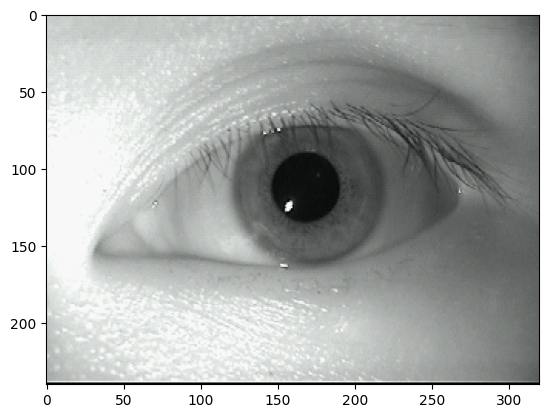

In [ ]:
# Exemple d'une image
plt.imshow(X[0])

## Split du jeu de données en données d'entrainement et données de test

In [ ]:
from sklearn.model_selection import train_test_split

# Division des données en ensembles d'entrainement et de test, tout en conservant la répartition des classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print("Dimensions de X_train : ", X_train.shape)
print("Dimensions de X_test : ", X_test.shape)
print("Dimensions de y_train : ", y_train.shape)
print("Dimensions de y_test : ", y_test.shape)

Dimensions de X_train :  (360, 240, 320, 3)
Dimensions de X_test :  (90, 240, 320, 3)
Dimensions de y_train :  (360,)
Dimensions de y_test :  (90,)


## Encodage des labels (Label Encoder)

Encode les classes cibles sous forme d'entiers avec une valeur comprise entre 0 et n_classes-1.

Ce transformateur doit être utilisé pour coder les valeurs cibles, c'est-à-dire y, et non l'entrée X.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html




In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
label_enc_lr = preprocessing.LabelEncoder()

In [ ]:
# Encodage des labels d'entrainement
y_train_enc = label_enc_lr.fit_transform(y_train)
# Encodage des labels de test
y_test_enc = label_enc_lr.fit_transform(y_test)

In [ ]:
# Montre les classes du Label Encoder
label_enc_lr.classes_

array(['left', 'right'], dtype='<U5')

## One-Hot Encoding des labels

- https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [ ]:
# To categorical
y_train_vect = to_categorical(y_train_enc)
# y_test_vect = to_categorical(y_test_enc) # pas besoin des cibles de test sous forme de vecteurs

In [ ]:
# Conversion en classes
label_enc_lr.classes_[np.argmax(y_train_vect[0])]

'right'

## Augmentation des données (Data Augmentation)

L'augmentation des données est une technique qui permet de créer artificiellement de nouvelles données à partir d'un ensemble de données existant. Ces nouvelles données sont générées en appliquant des transformations mineures aux données existantes, ou en utilisant d'autres modèles d'apprentissage automatique.

- https://www.tensorflow.org/tutorials/images/data_augmentation?hl=fr
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
# Creation d'une instance de ImageDataGenerator
# On applique les transformations souhaitées sur l'image
datagen = ImageDataGenerator(
  rotation_range=7,
  width_shift_range=0.1,
  height_shift_range=0.1,
  brightness_range=[0.5, 1.2],
  zoom_range=0.1,
  channel_shift_range=0.1,
  fill_mode='wrap' # reflect
)

In [ ]:
def augment_dataset(X_train, y_train, nb_aug_imgs):
  """
  Retourne un ndarray d'images augmentées utilisant 'datagen' (l'instance
  de la classe ImageDataGenerator) et leurs labels associés.
  """
  # Convertit les ndarray en listes
  if isinstance(X_train, np.ndarray):
    X_train = X_train.tolist()
  if isinstance(y_train, np.ndarray):
    y_train = y_train.tolist()

  augmented_images = []
  augmented_labels = []
  for img, label in zip(X_train, y_train) :
    # Ajoute une dimension supplémentaire au Tensor
    img = np.expand_dims(img, axis=0)
    # img = tf.cast(tf.expand_dims(ex_img, 0), tf.float32)
    # Compte le nombre d'itérations de la boucle
    batches = 0
    # Applique le ImageDataGenerator à l'image
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        batches += 1
        # Generer un nombre d'images puis sortir de la boucle
        if batches >= nb_aug_imgs:
          break
  augmented_images = np.array(augmented_images)
  augmented_labels = np.array(augmented_labels)
  return augmented_images, augmented_labels

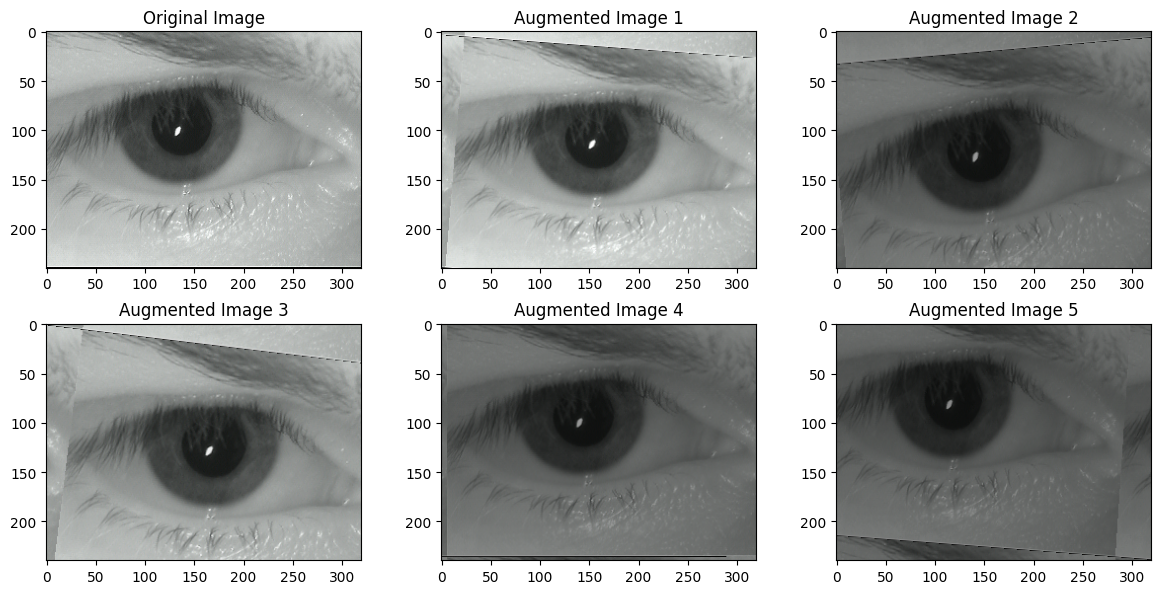

In [ ]:
# Visualisation d'un exemple d'image
img = tf.cast(tf.expand_dims(X_train[0], 0), tf.float32)
aug_ex_imgs, aug_ex_labels = augment_dataset(X_train[:1], y_train_vect[:1], 5)

# Display original and augmented images using matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
# plt.imshow(np.array(img[0]))
plt.imshow(img[0].astype(np.uint8)) # Les valeurs des pixels doivent être des entiers et non des nombres décimaux
plt.title('Original Image')

for i, augmented_img in enumerate(aug_ex_imgs):
    plt.subplot(2, 3, i + 2)
    plt.imshow(augmented_img.astype(np.uint8))
    plt.title(f'Augmented Image {i+1}')

plt.tight_layout()
plt.show()

### Augmentation des images d'entrainement

- https://sparkbyexamples.com/numpy/numpy-concatenate-arrays/

In [ ]:
# Géneration des images augmentées
augmented_images, augmented_labels = augment_dataset(X_train, y_train_vect, 5)

In [ ]:
# Ajout des images augmentées aux images d'entrainement
X_train_aug = np.concatenate((X_train, augmented_images))
y_train_aug = np.concatenate((y_train_vect, augmented_labels))

In [ ]:
X_train_aug.shape

(2160, 240, 320, 3)

In [ ]:
y_train_aug.shape

(2160, 2)

### Augmentation des images de test

In [ ]:
# Data augmentation des images de test
imgs_test_aug, labels_test_aug = augment_dataset(X_test, y_test_enc, 5)

# Ajout des images augmentées aux images de test
X_test_aug = np.concatenate((X_test, imgs_test_aug))
y_test_aug = np.concatenate((y_test_enc, labels_test_aug))

In [ ]:
X_test_aug.shape

(540, 240, 320, 3)

In [ ]:
y_test_aug.shape

(540,)

## Prétraitement de l'image : redimensionnemennt et mise à l'échelle

Les couches de prétraitement des images seront ajoutées aux couches du modèle, juste après la couche Input. Ces couches seront inclues dans le modèle, évitant ainsi de devoir les exporter séparemment.

- https://www.tensorflow.org/tutorials/images/data_augmentation?hl=fr#resizing_and_rescaling
- https://www.tensorflow.org/guide/keras/preprocessing_layers
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/CenterCrop

In [ ]:
# Couche de redimensionnement d'images
resizing_layer = tf.keras.layers.Resizing(
  img_height,
  img_width,
  interpolation='bilinear',
  crop_to_aspect_ratio=True
)

In [ ]:
# Couche de normalisation d'images
rescaling_layer = tf.keras.layers.Rescaling(scale=1./255)

In [ ]:
# Visualisation d'une image d'exemple
ex_img = X_train[7]
print(f"Shape de l'image : {ex_img.shape}")

Shape de l'image : (240, 320, 3)


In [ ]:
# Redimensionnement de l'image
ex_img_resized = resizing_layer(ex_img)

In [ ]:
# Mise à l'échelle de l'image (valeurs des pixels entre 0 et 1)
ex_img_resized_and_rescaled = rescaling_layer(ex_img_resized)

In [ ]:
print(f"Shape de l'image redimensionnée et normalisée : {ex_img_resized_and_rescaled.shape}")

Shape de l'image redimensionnée et normalisée : (240, 320, 3)


In [ ]:
# Verify that the pixels are in the [0, 1] range:
print("Valeurs minimum des pixels :", ex_img_resized_and_rescaled.numpy().min())
print("Valeurs maximum des pixels :", ex_img_resized_and_rescaled.numpy().max())

Valeurs minimum des pixels : 0.0
Valeurs maximum des pixels : 0.9725491


## Fonctions de callbacks pour l'entrainement

**ReduceLROnPlateau** : Ce callback permet de réduire le taux d'apprentissage si une métrique surveillée (généralement la perte de validation) ne s'améliore pas pendant un certain nombre d'époques. Cela peut aider à empêcher le modèle de se sur-adapter (over-fit) aux données d'entraînement.

**EarlyStopping** : Ce callback permet d'arrêter l'entraînement du modèle si une métrique surveillée ne s'améliore pas pendant un certain nombre d'époques. Cela peut aider à économiser du temps de calcul et à empêcher le modèle de se sur-adapter aux données d'entraînement.

In [ ]:
!pip install livelossplot --quiet

In [ ]:
# Live training loss plot
# Log-loss (cost function) and accuracy
from livelossplot import PlotLossesKeras

from keras.callbacks import ReduceLROnPlateau,EarlyStopping
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

## Architecture du modèle

`functional API` de Keras permet de créer des modèles qui sont plus flexibles qu'avec `Sequential API`. `functional API` peut accepter des modèles non-linaires, avec des couches partagées, ou même avec des entrées et sorties multiples.

L’idée principale est qu’un modèle d’apprentissage profond est généralement un `directed acyclic graph (DAG)` de couches. `functional API` est donc un moyen de créer des graphiques de couches.

- https://keras.io/guides/functional_api/
- https://keras.io/api/models/model/#model-class
- https://keras.io/api/layers/core_layers/input/
- https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc
- https://ressources.labomedia.org/keras_input_explanation

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten

NBCLASSES = 2

def create_model():

  # Couche d'entrée des images
  # La couche Input converti les données d'entrée en Keras tensor.
  # L'argument 'shape' ne doit pas inclure la dimension du batch (le nombre d'images)
  # La valeur '[None, None]' permet de passer une taille d'images libre, elles seront redimensionnées par la couche suivante
  inputs = Input(shape=[None, None] + [img_channels])

  # Pré-traitement des images
  # Couche de redimensionnement
  imgs_resized = resizing_layer(inputs)
  # Couche de normalisation
  imgs_rescaled = rescaling_layer(imgs_resized)

  # Modèle VGG16, pré-entrainé sur ImageNet
  vgg = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=imgs_rescaled, # Tenseur Keras facultatif (c'est-à-dire la sortie du layer.Input()) à utiliser comme entrée d'image pour le modèle.
    input_shape=(img_height, img_width, img_channels)
  )
  # Gèle des couches VGG avec les poids pré-entrainés
  for layer in vgg.layers:
      layer.trainable = False
  # Récupère la sortie de VGG
  vgg_out = vgg.output

  # Aplatissement
  x = Flatten()(vgg_out)
  # Couche de sortie : couche Dense pour nos classes de sorties
  outputs = Dense(NBCLASSES, activation='softmax')(x)

  # Création du modèle
  model = Model(inputs=inputs, outputs=outputs, name="lr_vgg16_imagenet_model_v2")
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
  model.summary()
  return model

lr_classifier = create_model()

58889256/58889256 [==============================] - 0s 0us/step
Model: "lr_vgg16_imagenet_model_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 240, 320, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                         

## Entrainement du modèle

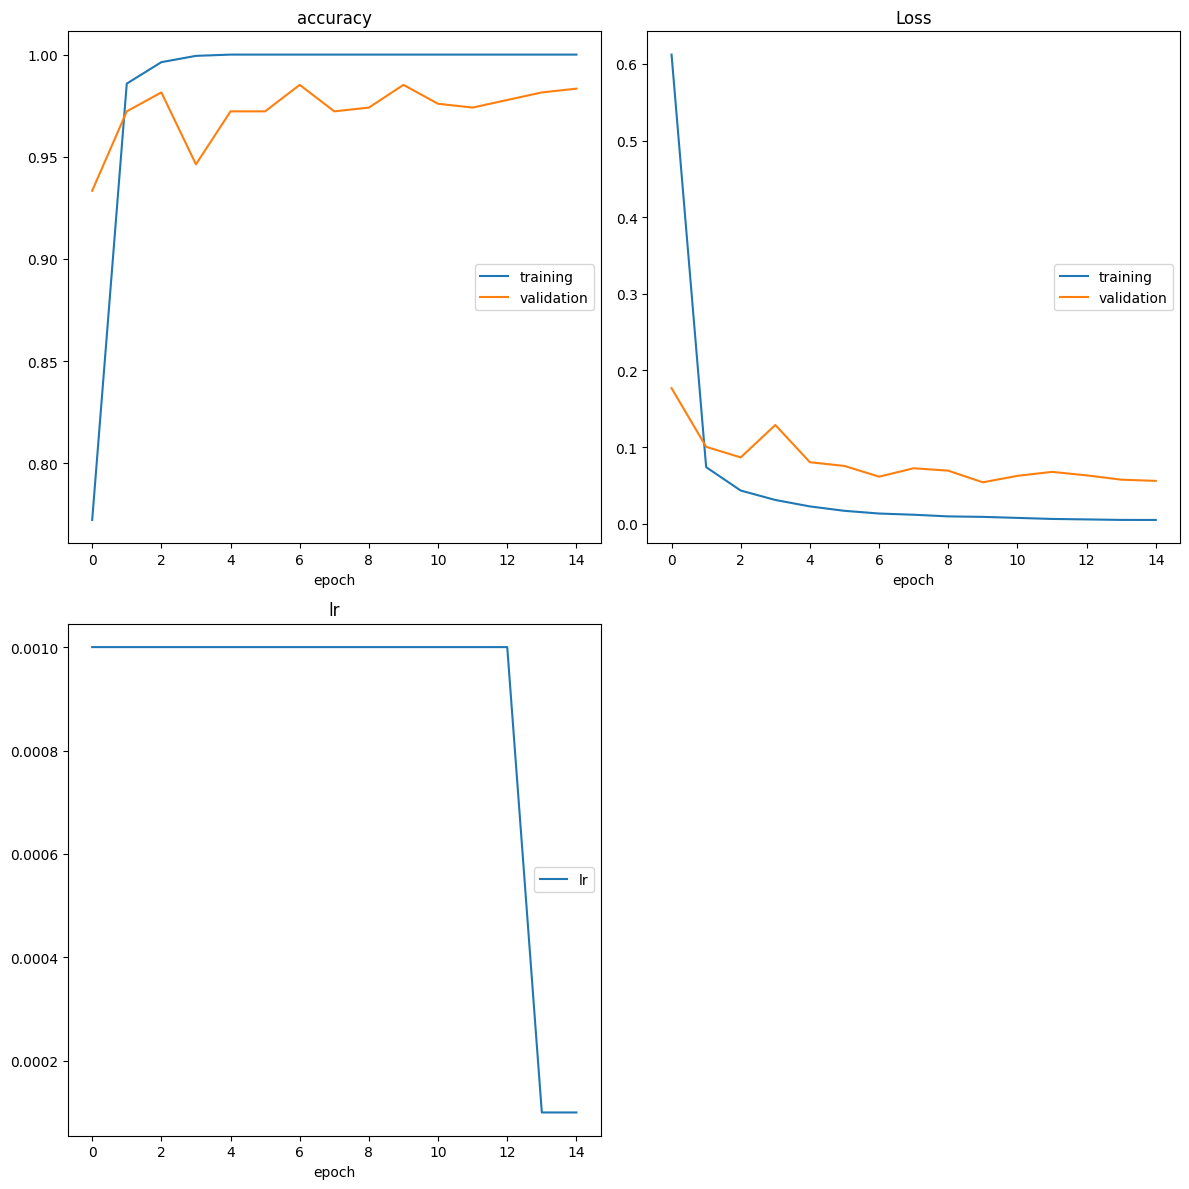

accuracy
	training         	 (min:    0.772, max:    1.000, cur:    1.000)
	validation       	 (min:    0.933, max:    0.985, cur:    0.983)
Loss
	training         	 (min:    0.005, max:    0.612, cur:    0.005)
	validation       	 (min:    0.054, max:    0.177, cur:    0.056)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
54/54 [==============================] - 14s 257ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0559 - val_accuracy: 0.9833 - lr: 1.0000e-04


In [ ]:
if TRAIN:
  lr_classifier_hist = lr_classifier.fit(
    X_train_aug,
    y_train_aug,
    batch_size=30,
    epochs=EPOCHS,
    validation_split=0.25,
    callbacks=[rlrop, early, PlotLossesKeras()]
  )

In [ ]:
lr_classifier_hist.history['val_accuracy']

[0.9333333373069763,
 0.9722222089767456,
 0.9814814925193787,
 0.9462962746620178,
 0.9722222089767456,
 0.9722222089767456,
 0.9851852059364319,
 0.9722222089767456,
 0.9740740656852722,
 0.9851852059364319,
 0.9759259223937988,
 0.9740740656852722,
 0.9777777791023254,
 0.9814814925193787,
 0.9833333492279053]

## Sauvegarde du modèle

- https://keras.io/api/saving/model_saving_and_loading/
- https://www.tensorflow.org/guide/keras/serialization_and_saving


In [ ]:
# lr_classifier_path_keras = backup_folder + "lr_classifier.keras"
lr_classifier_path = backup_folder + "lr_classifier_v2.h5"

In [ ]:
if TRAIN :
  # lr_classifier.save(lr_classifier_path_keras)
  lr_classifier.save(lr_classifier_path, save_format='h5', overwrite=True)

## Sauvegarde du Label Encoder

- https://www.digitalocean.com/community/tutorials/python-pickle-example

In [ ]:
lr_label_encoder_path = backup_folder + 'lr_label_encoder.pkl'

In [ ]:
if TRAIN :
	# Open a file and use dump()
	# 'wb' = write binary
	with open(lr_label_encoder_path, 'wb') as file:
		# A new file will be created
		pickle.dump(label_enc_lr, file)
	# close the file
	file.close()

## Importer le modèle et le label encoder

### Importer le modèle

In [ ]:
# Importer le modèle 'LR Classifier'
lr_classifier_restored = tf.keras.models.load_model(lr_classifier_path)
lr_classifier_restored.summary()

Model: "lr_vgg16_imagenet_model_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 240, 320, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120,

- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible

### Importer le label encoder

In [ ]:
# Importer le label encoder
# 'rb' = read binary
with open(lr_label_encoder_path, 'rb') as f:
  label_enc_lr_loaded = pickle.load(f) # deserialize using load()

label_enc_lr_loaded.classes_

array(['left', 'right'], dtype='<U5')

## Prédictions avec les données de test (augmentées)

In [ ]:
# Prédiction avec les données de test (augmentées)
y_pred = np.argmax(lr_classifier_restored.predict(X_test_aug), axis=1)

17/17 [==============================] - 22s 426ms/step


## Performances

### Métriques

In [ ]:
# One-Hot Encoding des cibles de test (qui étaient restées au format encodées)
y_test_aug_to_cat = to_categorical(y_test_aug)

In [ ]:
loss, acc = lr_classifier_restored.evaluate(X_test_aug, y_test_aug_to_cat, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

17/17 - 3s - loss: 0.0395 - accuracy: 0.9907 - 3s/epoch - 202ms/step
Restored model, accuracy: 99.07%


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcul des mesures de performance
accuracy = accuracy_score(y_test_aug, y_pred)
precision = precision_score(y_test_aug, y_pred,average='macro')
recall = recall_score(y_test_aug, y_pred,average='macro')
f1 = f1_score(y_test_aug, y_pred,average='macro')

print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

Précision : 0.99
Rappel : 0.99
Score F1 : 0.99
Exactitude : 0.99


### Matrice de confusion

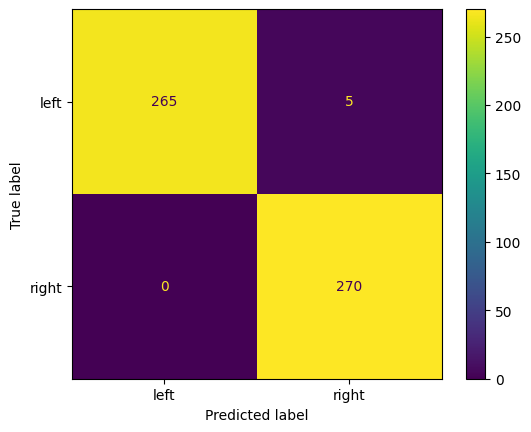

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_aug, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_enc_lr.classes_)
disp.plot()
plt.show()

## Inférence avec une image

In [ ]:
def lr_inference(image_file):
  """
  Fonction qui réalise une prédiction à partir d'un fichier image (ndarray ou PIL Image).
  """
  # Ajout d'une dimension car le modèle accepte une liste d'images cad un objet à 4 dimensions.
  image_file_more_dims = np.expand_dims(image_file, axis=0)
  # Inférence
  pred = lr_classifier_restored.predict(image_file_more_dims)
  pred_index = np.argmax(pred, axis=1)[0]
  # Désencodage de l'index de classe en classe (string)
  pred_class = label_enc_lr_loaded.classes_[pred_index]
  pred_score = np.max(pred)
  # Retourne une string
  return pred_class, pred_score

In [ ]:
# Selection d'une image de test
test_img = X_test[0]

In [ ]:
lr_inference(test_img)

1/1 [==============================] - 0s 57ms/step


('right', 0.998958)

In [ ]:
# Classe pour cette image
y_test[0]

'right'

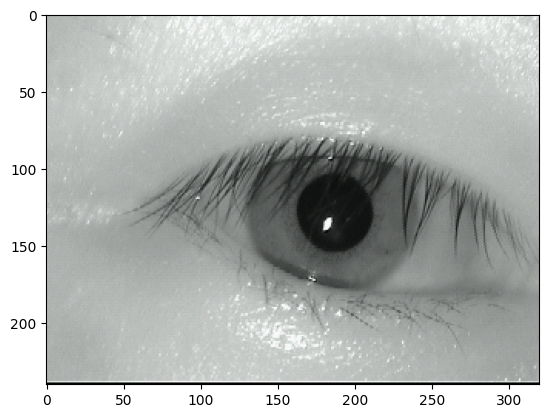

In [ ]:
plt.imshow(test_img)

## Montrer les images mal classées

In [ ]:
# Liste de booléens, retourne True quand l'image est mal prédite par le modèle
missed_bool_list = y_pred != y_test_aug

In [ ]:
# Images mal classées
missed_imgs = X_test_aug[missed_bool_list]
# Prédiction du classifieur
missed_pred = np.array(y_pred)[missed_bool_list]
# Réalité terrain
missed_truth = y_test_aug[missed_bool_list]

In [ ]:
# Prédiction du classifieur
label_enc_lr.classes_[missed_pred]

array(['right', 'right', 'right', 'right', 'right'], dtype='<U5')

In [ ]:
# Réalité terrain
label_enc_lr.classes_[missed_truth]

array(['left', 'left', 'left', 'left', 'left'], dtype='<U5')

In [ ]:
# Compte des images mal classées
missed_imgs_count = int(len(missed_imgs))
print(f"Il y a {missed_imgs_count} images pour lesquelles le classificateur commet une erreur.")

Il y a 5 images pour lesquelles le classificateur commet une erreur.


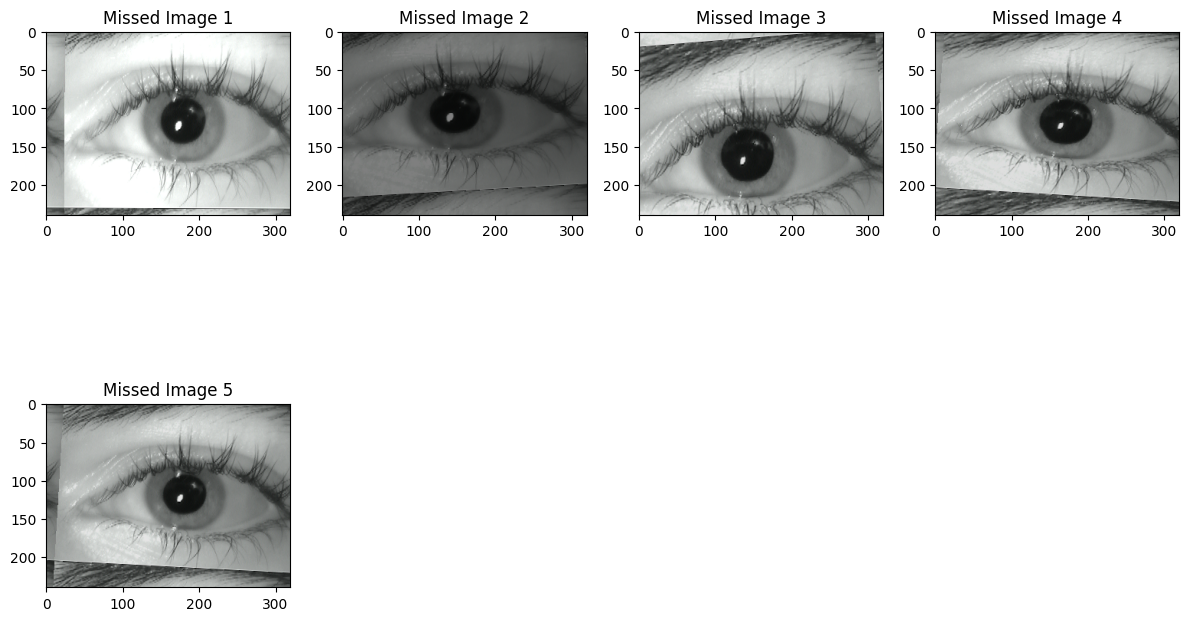

In [ ]:
import math

# Montrer les images mal classées
cols = 4
rows = math.ceil(missed_imgs_count / cols)
plt.figure(figsize=(12, 8))
for i, img in enumerate(missed_imgs):
  plt.subplot(rows, cols, i + 1)
  plt.imshow(img.astype(np.uint8))
  plt.title(f'Missed Image {i+1}')
plt.tight_layout()
plt.show()